In [1]:
import pandas as pd
import geopandas as gpd

In [7]:
CITIES = ['Nashville', 'Chattanooga', 'Memphis', 'Knoxville']
# CITIES = ['Chattanooga']

income = pd.read_csv('../data/income/ACSDT5Y2022.B19013-Data.csv')[1:]
income['GEO_ID'] = income['GEO_ID'].astype(str)

cbg = gpd.read_file('../data/tl_2022_47_bg.zip')[['GEOID', 'geometry']]
cbg['GEOID'] = cbg['GEOID'].astype(str)

tn_city_boundaries = gpd.read_file("zip:///home/rishav/Programs/move_od/data/TN_City_Boundaries.zip")
city_limits = pd.DataFrame()
for city in CITIES:
    city_limits = pd.concat([city_limits, tn_city_boundaries[tn_city_boundaries['NAME'] == city]])
city_limits = city_limits.to_crs('EPSG:4326')

In [8]:
income['GEO_ID'] = income['GEO_ID'].apply(lambda x: x.split('US')[1])
income = income.rename({'GEO_ID': 'GEOID', 'B19013_001E': 'estimate', 'B19013_001M': 'margin_of_error'}, axis=1)
income['estimate'] = income['estimate'].replace({'-': 0, '**': 0})  # Adjust as necessary
income['margin_of_error'] = income['margin_of_error'].replace({'-': 0, '**': 0})
income['estimate'] = income['estimate'].replace({
    '-': '0', 
    '\*\*': '0', 
    '\+': '', 
    ',': '',
    '\*': ''  # Add this line to handle asterisks
}, regex=True)
income['margin_of_error'] = income['margin_of_error'].replace({
    '-': '0', 
    '\*\*': '0', 
    '\+': '', 
    ',': '',
    '\*': ''  # Add this line to handle asterisks
}, regex=True)

income = income.merge(cbg, on='GEOID')
income = gpd.GeoDataFrame(income, geometry='geometry')
income = income.to_crs(city_limits.crs)
income.to_csv('outputs/income_tn_all.csv')
# dest_within_city = income
# dest_within_city = income[income.geometry.within(city_limits.unary_union)]


In [399]:
dest_within_city = gpd.sjoin(city_limits, income, how="inner", predicate='intersects')

In [400]:
dest_within_city = income.loc[dest_within_city.index_right]

In [402]:
dest_within_city = dest_within_city.drop(['Unnamed: 4'], axis=1)
dest_within_city = dest_within_city.to_crs(epsg=4326)

dest_within_city = dest_within_city[dest_within_city['geometry'].is_valid]

dest_within_city.to_csv('./outputs/income_tn.csv')
dest_within_city.to_file('./outputs/income_tn.geojson', driver='GeoJSON')

: 

<AxesSubplot:>

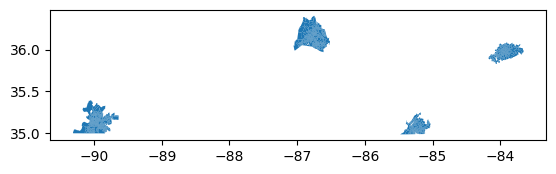

In [396]:
dest_within_city.plot()

## Combine multi year

In [297]:
import glob
import os

folder_path = '../data/2018-2022_5year_ACS_median_income/'
pattern = os.path.join(folder_path, '*-Data.csv')

file_list = glob.glob(pattern)
df_list = [pd.read_csv(file, low_memory=False)[1:] for file in file_list]
combined_income = pd.concat(df_list)

combined_income['GEO_ID'] = combined_income['GEO_ID'].astype(str)
combined_income['GEO_ID'] = combined_income['GEO_ID'].apply(lambda x: x.split('US')[1])
combined_income = combined_income.rename({'GEO_ID': 'GEOID', 'B19013_001E': 'estimate', 'B19013_001M': 'margin_of_error'}, axis=1)

combined_income['estimate'] = combined_income['estimate'].replace({
    '-': '0', 
    '\*\*': '0', 
    '\+': '', 
    ',': '',
    '\*': ''  # Add this line to handle asterisks
}, regex=True)

combined_income['margin_of_error'] = combined_income['margin_of_error'].replace({
    '-': '0', 
    '\*\*': '0', 
    '\+': '', 
    ',': '',
    '\*': ''  # Add this line to handle asterisks
}, regex=True)

combined_income['estimate'] = combined_income['estimate'].astype(float)
combined_income['margin_of_error'] = combined_income['margin_of_error'].astype(float)
combined_income = combined_income.groupby(['GEOID']).agg({'estimate':'mean', 'margin_of_error': 'mean'}).reset_index()

In [298]:
combined_income = combined_income.merge(cbg[['GEOID', 'geometry']], on='GEOID')
combined_income = gpd.GeoDataFrame(combined_income, geometry='geometry')
combined_income = combined_income.to_crs(city_limits.crs)

In [299]:
combined_income_within_city = gpd.sjoin(city_limits[['geometry']], combined_income, how="inner", predicate='intersects')

In [300]:
combined_income_within_city = combined_income_within_city.to_crs(epsg=4326)

combined_income_within_city = combined_income_within_city[combined_income_within_city['geometry'].is_valid]

combined_income_within_city.to_csv('./outputs/10_year_income_tn.csv')
combined_income_within_city.to_file('./outputs/10_year_income_tn.geojson', driver='GeoJSON')